In [1]:
# IMPORTS

import pandas as pd
import h5py
import numpy as np
import sys
import matplotlib.pyplot as plt
import neurokit2 as nk
import random
import networkx as nx
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx # Visualization
import matplotlib.pyplot as plt
from torch.nn import Linear                   # Define layers
from torch_geometric.nn import GCNConv
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d 
import pywt # pip install PyWavelets
from scipy.signal import medfilt
import cv2 # pip install opencv-python  

In [2]:
# CARREGAR OS DADOS

def carregar_ecgs(unlabel, umdavb, rbbb, lbbb, sb, st, af, filtrado):

    caminho_arquivo = "../../Projeto/Database/exams.csv"
    dados = pd.read_csv(caminho_arquivo)
    arquivos_usados = ["exams_part0.hdf5", "exams_part1.hdf5",
                    "exams_part2.hdf5", "exams_part3.hdf5", "exams_par4.hdf5", "exams_part5.hdf5",
                    "exams_part6.hdf5", "exams_part7.hdf5", "exams_par8.hdf5", "exams_part9.hdf5",
                    "exams_part10.hdf5", "exams_part11.hdf5", "exams_part12.hdf5", "exams_part13.hdf5", 
                    "exams_part14.hdf5", "exams_part15.hdf5", "exams_part16.hdf5", "exams_part17.hdf5"]

    ecg_normal_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[(dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]



    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    caminho_interferencias = "../../Projeto/Database/resultados_interferencia.csv"
    interferencias = pd.read_csv(caminho_interferencias)
    interferencias_ids = interferencias['exam_id'].tolist()

    ecg_normal_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) ]
    
    ecg_umdavb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == True) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_rbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == True) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_lbbb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == True) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_sb_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == True) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_st_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == True) &
                                    (dados.iloc[:, 9] == False) &
                                    (dados.iloc[:, 13] == False)]
    
    ecg_af_linhas = dados.index[~dados['exam_id'].isin(interferencias_ids) &
                                    (dados.iloc[:, 14].isin(arquivos_usados)) &
                                    (dados.iloc[:, 4] == False) &
                                    (dados.iloc[:, 5] == False) &
                                    (dados.iloc[:, 6] == False) &
                                    (dados.iloc[:, 7] == False) &
                                    (dados.iloc[:, 8] == False) &
                                    (dados.iloc[:, 9] == True) &
                                    (dados.iloc[:, 13] == False)]

    print("Tirando Interferência:")
    print("Número de linhas ecg_normal_linhas:", len(ecg_normal_linhas))
    print("Número de linhas ecg_umdavb_linhas:", len(ecg_umdavb_linhas))
    print("Número de linhas ecg_rbbb_linhas:", len(ecg_rbbb_linhas))
    print("Número de linhas ecg_lbbb_linhas:", len(ecg_lbbb_linhas))
    print("Número de linhas ecg_sb_linhas:", len(ecg_sb_linhas))
    print("Número de linhas ecg_st_linhas:", len(ecg_st_linhas))
    print("Número de linhas ecg_af_linhas:", len(ecg_af_linhas))

    ecg_normal_id = dados.iloc[ecg_normal_linhas, 0].tolist()
    ecg_umdavb_id = dados.iloc[ecg_umdavb_linhas, 0].tolist()
    ecg_rbbb_id = dados.iloc[ecg_rbbb_linhas, 0].tolist()
    ecg_lbbb_id = dados.iloc[ecg_lbbb_linhas, 0].tolist()
    ecg_sb_id = dados.iloc[ecg_sb_linhas, 0].tolist()
    ecg_st_id = dados.iloc[ecg_st_linhas, 0].tolist()
    ecg_af_id = dados.iloc[ecg_af_linhas, 0].tolist()

    random.seed(42) 

    ecg_normal_sample = random.sample(ecg_normal_id, unlabel) if len(ecg_normal_id) >= unlabel else ecg_normal_id
    ecg_umdavb_sample = random.sample(ecg_umdavb_id, umdavb) if len(ecg_umdavb_id) >= umdavb else ecg_umdavb_id
    ecg_rbbb_sample = random.sample(ecg_rbbb_id, rbbb) if len(ecg_rbbb_id) >= rbbb else ecg_rbbb_id
    ecg_lbbb_sample = random.sample(ecg_lbbb_id, lbbb) if len(ecg_lbbb_id) >= lbbb else ecg_lbbb_id
    ecg_sb_sample = random.sample(ecg_sb_id, sb) if len(ecg_sb_id) >= sb else ecg_sb_id
    ecg_st_sample = random.sample(ecg_st_id, st) if len(ecg_st_id) >= st else ecg_st_id
    ecg_af_sample = random.sample(ecg_af_id, af) if len(ecg_af_id) >= af else ecg_af_id

    ids_ecgs = ecg_normal_sample + ecg_umdavb_sample + ecg_rbbb_sample + ecg_lbbb_sample + ecg_sb_sample + ecg_st_sample + ecg_af_sample

    print("Número de ecgs pra usar:", len(ids_ecgs))

    
    if filtrado == True: arquivos_hdf5 = ["/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_0_1.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_2_3.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_4_5.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_6_7.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_8_9.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_10_11.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_12_13.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_14_15.hdf5",
                        "/scratch/guilherme.evangelista/Clustering-Paper/Projeto/Database/filtered_exams_16_17.hdf5"]
    
    else: arquivos_hdf5 = ['/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part0.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part1.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part2.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part3.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part4.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part5.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part6.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part7.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part8.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part9.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part10.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part11.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part12.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part13.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part14.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part15.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part16.hdf5',
                 '/scratch/pedro.bacelar/Clustering-Paper/Projeto/Database/exams_part17.hdf5']
        
    

    def get_ecg_data(file_path, exam_id):
        with h5py.File(file_path, 'r') as f:
            # Obter os IDs dos exames
            exam_ids = np.array(f['exam_id'])

            # Encontrar o índice correspondente ao exam_id de interesse
            exam_index = np.where(exam_ids == exam_id)[0]

            if len(exam_index) == 0:
                raise ValueError("Exam ID não encontrado.")
            else:
                exam_index = exam_index[0]
                # Acessar os tracings de ECG correspondentes ao exam_index
                exam_tracings = f['tracings'][exam_index]
                # Preencher tracings nulos com epsilon
                return exam_tracings

    exam_ids_to_cluster = ids_ecgs  # Substitua pelos IDs reais dos exames

    # Lista para armazenar todos os tracings de ECG
    all_tracings = []

    # Obter os tracings de ECG para cada exam_id e armazenar na lista
    for exam_id in exam_ids_to_cluster:
        found = False  # Sinalizador para verificar se o exame foi encontrado em algum arquivo
        for arquivo in arquivos_hdf5:
            try:
                tracings = get_ecg_data(arquivo, exam_id)
                if tracings is not None:
                    tracing_transposto = np.array(tracings).T
                    all_tracings.append(tracing_transposto)
                    found = True  # Sinalizador para indicar que o exame foi encontrado
                    break  # Se encontrou, não precisa continuar buscando nos outros arquivos
            except ValueError as e:
                i = 0
            except Exception as e:
                i = 0
        
        if not found:
            print(f"Erro: exame ID {exam_id} não encontrado em nenhum dos arquivos.")

    # Verifique o tamanho da lista all_tracings para garantir que os dados foram coletados corretamente
    print("Número de ecgs que eram pra ser processados:", len(ids_ecgs))
    print(f"Número total de traçados processados: {len(all_tracings)}")

    # X será um array com um único array dentro, contendo todos os números do tracings.T
    X = np.array(all_tracings)
    return X , ids_ecgs

In [3]:
X, ids_ecgs = carregar_ecgs(unlabel=10,umdavb=10,rbbb=10,lbbb=10,sb=10,st=10,af=10,filtrado=True)

Número de linhas ecg_normal_linhas: 272407
Número de linhas ecg_umdavb_linhas: 3735
Número de linhas ecg_rbbb_linhas: 6808
Número de linhas ecg_lbbb_linhas: 4176
Número de linhas ecg_sb_linhas: 4300
Número de linhas ecg_st_linhas: 6146
Número de linhas ecg_af_linhas: 4964
Tirando Interferência:
Número de linhas ecg_normal_linhas: 252167
Número de linhas ecg_umdavb_linhas: 3651
Número de linhas ecg_rbbb_linhas: 6703
Número de linhas ecg_lbbb_linhas: 4122
Número de linhas ecg_sb_linhas: 4248
Número de linhas ecg_st_linhas: 6038
Número de linhas ecg_af_linhas: 4804
Número de ecgs pra usar: 70
Número de ecgs que eram pra ser processados: 70
Número total de traçados processados: 70


In [4]:
print("Dimensão dos dados carregados:", X.shape)

Dimensão dos dados carregados: (70, 12, 4096)


In [5]:
import numpy as np

def get_my_dataset(X, unlabel=10,umdavb=10,rbbb=10,lbbb=10,sb=10,st=10,af=10,train_ratio=0.8):
    """
    Prepara o dataset de ECG para o treinamento.
    
    Parâmetros:
      - X: array de ECG (formato: [n_samples, n_channels, length])
      - os números de amostras por classe (deve coincidir com a ordem de concatenação na função carregar_ecgs)
      - train_ratio: proporção dos dados para treinamento
      
    Retorna:
      - X (possivelmente normalizado),
      - y: vetor de labels (0: normal, 1: umdavb, 2: rbbb, 3: lbbb, 4: sb, 5: st, 6: af)
      - train_idx: índices de treinamento
      - test_idx: índices de teste
    """
    
    total_samples = unlabel + umdavb + rbbb + lbbb + sb + st + af
    if X.shape[0] != total_samples:
        raise ValueError(f"O número de traçados em X ({X.shape[0]}) não corresponde à soma esperada ({total_samples}).")
    
    # Cria os labels de acordo com a ordem de concatenação
    y = np.array([0]*unlabel + 
                 [1]*umdavb + 
                 [2]*rbbb + 
                 [3]*lbbb + 
                 [4]*sb + 
                 [5]*st + 
                 [6]*af)
    
    # Aqui assumimos que a normalização é feita sobre o último eixo (tempo)
    X_norm = X.copy().astype(np.float32)
    for i in range(X_norm.shape[0]):
        # Evita divisão por zero
        mean_val = X_norm[i].mean()
        std_val = X_norm[i].std() if X_norm[i].std() != 0 else 1.0
        X_norm[i] = (X_norm[i] - mean_val) / std_val
    
    # Cria a divisão em treinamento e teste (shuffle dos índices)
    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    split = int(train_ratio * total_samples)
    train_idx = indices[:split]
    test_idx = indices[split:]
    
    return X_norm, y, train_idx, test_idx


In [ ]:
import os
import uuid
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.utils.data
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


class SimTSCTrainer:
    def __init__(self, device, logger):
        self.device = device
        self.logger = logger
        self.tmp_dir = 'tmp'
        if not os.path.exists(self.tmp_dir):
            os.makedirs(self.tmp_dir)

    def fit(self, model, X, y, train_idx, distances, K, alpha, test_idx=None, report_test=False, batch_size=128, epochs=500):
        self.K = K
        self.alpha = alpha

        train_batch_size = min(batch_size//2, len(train_idx))
        other_idx = np.array([i for i in range(len(X)) if i not in train_idx])
        other_batch_size = min(batch_size - train_batch_size, len(other_idx))
        train_dataset = Dataset(train_idx)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1)

        if report_test and test_idx is not None:
            test_batch_size = min(batch_size//2, len(test_idx))
            other_idx_test = np.array([i for i in range(len(X)) if i not in test_idx])
            other_batch_size_test = min(batch_size - test_batch_size, len(other_idx_test))
            test_dataset = Dataset(test_idx)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=1)

        self.adj = torch.from_numpy(distances.astype(np.float32))
        self.X, self.y = torch.from_numpy(X), torch.from_numpy(y)
        file_path = os.path.join(self.tmp_dir, str(uuid.uuid4()))
        optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=4e-3)
        best_acc = 0.0

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            for sampled_train_idx in train_loader:
                sampled_other_idx = np.random.choice(other_idx, other_batch_size, replace=False)
                idx = np.concatenate((sampled_train_idx, sampled_other_idx))
                _X = self.X[idx].to(self.device)
                _y = self.y[sampled_train_idx].to(self.device)
                _adj = self.adj[idx][:, idx]
                outputs = model(_X, _adj, K, alpha)
                loss = F.nll_loss(outputs[:len(sampled_train_idx)], _y)
                loss.backward()
                optimizer.step()

            model.eval()
            acc = compute_accuracy(
                model, self.X, self.y, self.adj, self.K, self.alpha,
                train_loader, self.device, other_idx, other_batch_size
            )
            
            # --------------------------------------------------------------------------
            # ADIÇÃO DO F1 SCORE: cálculo do F1 para o conjunto de treinamento
            # --------------------------------------------------------------------------
            f1 = compute_f1(
                model, self.X, self.y, self.adj, self.K, self.alpha,
                train_loader, self.device, other_idx, other_batch_size
            )

            if acc >= best_acc:
                best_acc = acc
                torch.save(model.state_dict(), file_path)

            if report_test and test_idx is not None:
                test_acc = compute_accuracy(
                    model, self.X, self.y, self.adj, self.K, self.alpha,
                    test_loader, self.device, other_idx_test, other_batch_size_test
                )
                
                # ----------------------------------------------------------------------
                # ADIÇÃO DO F1 SCORE: cálculo do F1 para o conjunto de teste
                # ----------------------------------------------------------------------
                test_f1 = compute_f1(
                    model, self.X, self.y, self.adj, self.K, self.alpha,
                    test_loader, self.device, other_idx_test, other_batch_size_test
                )

                self.logger.log('--> Epoch {}: loss {:5.4f}; accuracy: {:5.4f}; best accuracy: {:5.4f}; test accuracy: {:5.4f}'.format(
                    epoch, loss.item(), acc, best_acc, test_acc
                ))
                # Log separado do F1 Score (não alteramos a linha existente; apenas adicionamos)
                self.logger.log('----> F1: {:5.4f}; Test F1: {:5.4f}'.format(f1, test_f1))

            else:
                self.logger.log('--> Epoch {}: loss {:5.4f}; accuracy: {:5.4f}; best accuracy: {:5.4f}'.format(
                    epoch, loss.item(), acc, best_acc
                ))
                # Log separado do F1 Score
                self.logger.log('----> F1: {:5.4f}'.format(f1))

        model.load_state_dict(torch.load(file_path))
        model.eval()
        os.remove(file_path)
        return model

    def test(self, model, test_idx, batch_size=128):
        test_batch_size = min(batch_size//2, len(test_idx))
        other_idx_test = np.array([i for i in range(len(self.X)) if i not in test_idx])
        other_batch_size_test = min(batch_size - test_batch_size, len(other_idx_test))
        test_dataset = Dataset(test_idx)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=1)
        acc = compute_accuracy(
            model, self.X, self.y, self.adj, self.K, self.alpha,
            test_loader, self.device, other_idx_test, other_batch_size_test
        )
        
        # --------------------------------------------------------------------------
        # ADIÇÃO DO F1 SCORE: cálculo do F1 no teste (apenas informado aqui)
        # --------------------------------------------------------------------------
        f1 = compute_f1(
            model, self.X, self.y, self.adj, self.K, self.alpha,
            test_loader, self.device, other_idx_test, other_batch_size_test
        )

        # Se quiser logar aqui, poderia adicionar algo como:
        # self.logger.log(f'Test F1: {f1:.4f}')
        
        return acc.item()

def compute_accuracy(model, X, y, adj, K, alpha, loader, device, other_idx, other_batch_size):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx in loader:
            sampled_other_idx = np.random.choice(other_idx, other_batch_size, replace=False)
            idx = np.concatenate((batch_idx, sampled_other_idx))
            _X = X[idx].to(device)
            _y = y[idx][:len(batch_idx)].to(device)
            _adj = adj[idx][:, idx]
            outputs = model(_X, _adj, K, alpha)
            preds = outputs[:len(batch_idx)].max(1)[1].type_as(_y)
            _correct = preds.eq(_y).double()
            correct += _correct.sum()
            total += len(batch_idx)
    acc = correct / total
    return acc

def compute_f1(model, X, y, adj, K, alpha, loader, device, other_idx, other_batch_size):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_idx in loader:
            sampled_other_idx = np.random.choice(other_idx, other_batch_size, replace=False)
            idx = np.concatenate((batch_idx, sampled_other_idx))
            _X = X[idx].to(device)
            _y = y[idx][:len(batch_idx)].to(device)
            _adj = adj[idx][:, idx]
            outputs = model(_X, _adj, K, alpha)
            preds = outputs[:len(batch_idx)].max(1)[1]
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(_y.cpu().numpy().tolist())
    # Usamos 'macro' por ser comum em multi-classes (pode ajustar se preferir)
    return f1_score(all_labels, all_preds, average='macro')

def compute_loss(model, X, y, adj, K, alpha, test_idx, device, batch_size=128):
    criterion = nn.NLLLoss()
    total_loss = 0.0
    total_samples = 0
    
    # Converter para tensores do PyTorch
    X = torch.tensor(X, dtype=torch.float32, device=device)
    y = torch.tensor(y, dtype=torch.long, device=device)
    adj = torch.tensor(adj, dtype=torch.float32, device=device)
    
    test_dataset = Dataset(test_idx)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    
    with torch.no_grad():
        for batch_idx in test_loader:
            _X = X[batch_idx]
            _y = y[batch_idx]
            _adj = adj[batch_idx][:, batch_idx]
            outputs = model(_X, _adj, K, alpha)
            loss = criterion(outputs, _y)
            total_loss += loss.item() * len(batch_idx)
            total_samples += len(batch_idx)
    
    return total_loss / total_samples




def compute_f1_per_class(model, X, y, adj, K, alpha, test_idx, device, batch_size=128):
    all_preds = []
    all_labels = []
    
    # Converter para tensores do PyTorch
    X = torch.tensor(X, dtype=torch.float32, device=device)
    y = torch.tensor(y, dtype=torch.long, device=device)
    adj = torch.tensor(adj, dtype=torch.float32, device=device)
    
    test_dataset = Dataset(test_idx)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)
    
    with torch.no_grad():
        for batch_idx in test_loader:
            _X = X[batch_idx]
            _y = y[batch_idx]
            _adj = adj[batch_idx][:, batch_idx]
            outputs = model(_X, _adj, K, alpha)
            preds = outputs.max(1)[1]
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(_y.cpu().numpy().tolist())
    
    f1_per_class = f1_score(all_labels, all_preds, average=None)  # F1 por classe
    f1_macro = f1_score(all_labels, all_preds, average='macro')  # F1 macro
    return f1_per_class, f1_macro

class SimTSC(nn.Module):
    def __init__(self, input_size, nb_classes, num_layers=1, n_feature_maps=64, dropout=0.5):
        super(SimTSC, self).__init__()
        self.num_layers = num_layers
        self.block_1 = ResNetBlock(input_size, n_feature_maps)
        self.block_2 = ResNetBlock(n_feature_maps, n_feature_maps)
        self.block_3 = ResNetBlock(n_feature_maps, n_feature_maps)
        if self.num_layers == 1:
            self.gc1 = GraphConvolution(n_feature_maps, nb_classes)
        elif self.num_layers == 2:
            self.gc1 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc2 = GraphConvolution(n_feature_maps, nb_classes)
            self.dropout = dropout
        elif self.num_layers == 3:
            self.gc1 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc2 = GraphConvolution(n_feature_maps, n_feature_maps)
            self.gc3 = GraphConvolution(n_feature_maps, nb_classes)
            self.dropout = dropout

    def forward(self, x, adj, K, alpha):
        ranks = torch.argsort(adj, dim=1)
        sparse_index = [[], []]
        sparse_value = []
        for i in range(len(adj)):
            _sparse_value = []
            for j in ranks[i][:K]:
                sparse_index[0].append(i)
                sparse_index[1].append(j)
                _sparse_value.append(1/np.exp(alpha*adj[i][j]))
            _sparse_value = np.array(_sparse_value)
            _sparse_value /= _sparse_value.sum()
            sparse_value.extend(_sparse_value.tolist())
        sparse_index = torch.LongTensor(sparse_index)
        sparse_value = torch.FloatTensor(sparse_value)
        adj = torch.sparse.FloatTensor(sparse_index, sparse_value, adj.size())
        device = self.gc1.bias.device
        adj = adj.to(device)

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = F.avg_pool1d(x, x.shape[-1]).squeeze()

        if self.num_layers == 1:
            x = self.gc1(x, adj)
        elif self.num_layers == 2:
            x = F.relu(self.gc1(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = self.gc2(x, adj)
        elif self.num_layers == 3:
            x = F.relu(self.gc1(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = F.relu(self.gc2(x, adj))
            x = F.dropout(x, self.dropout, training=self.training)
            x = self.gc3(x, adj)

        x = F.log_softmax(x, dim=1)
        return x

class GraphConvolution(Module):
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(0))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.expand = True if in_channels < out_channels else False
        self.conv_x = nn.Conv1d(in_channels, out_channels, 7, padding=3)
        self.bn_x = nn.BatchNorm1d(out_channels)
        self.conv_y = nn.Conv1d(out_channels, out_channels, 5, padding=2)
        self.bn_y = nn.BatchNorm1d(out_channels)
        self.conv_z = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn_z = nn.BatchNorm1d(out_channels)
        if self.expand:
            self.shortcut_y = nn.Conv1d(in_channels, out_channels, 1)
        self.bn_shortcut_y = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = F.relu(self.bn_x(self.conv_x(x)))
        out = F.relu(self.bn_y(self.conv_y(out)))
        out = self.bn_z(self.conv_z(out))
        if self.expand:
            x = self.shortcut_y(x)
        x = self.bn_shortcut_y(x)
        out += x
        out = F.relu(out)
        return out

class Dataset(torch.utils.data.Dataset):
    def __init__(self, idx):
        self.idx = idx

    def __getitem__(self, index):
        return self.idx[index]

    def __len__(self):
        return len(self.idx)


In [7]:
import os
import numpy as np
import torch
import time
import sys
from tqdm import tqdm
from dtaidistance import dtw
from joblib import Parallel, delayed

class Logger:
    def __init__(self, f):
        self.f = f
        
    def log(self, content):
        print(content)
        self.f.write(content + '\n')
        self.f.flush()

def train_model(X, y, train_idx, test_idx, distances, device, K=3, alpha=0.3, epochs=50):
    nb_classes = len(np.unique(y))
    input_size = X.shape[1]
    
    model = SimTSC(input_size, nb_classes)
    model = model.to(device)
    
    log_dir = './logs'
    os.makedirs(log_dir, exist_ok=True)
        
    log_path = os.path.join(log_dir, 'simtsc_ecg_log.txt')
    with open(log_path, 'w') as f:
        logger = Logger(f)
        trainer = SimTSCTrainer(device, logger)
        
        print("Iniciando o treinamento...")
        model = trainer.fit(
            model, X, y, train_idx, distances, 
            K, alpha, test_idx=test_idx, 
            report_test=True, epochs=epochs
        )
        
        acc = trainer.test(model, test_idx)
        loss = compute_loss(model, X, y, distances, K, alpha, test_idx, device)
        f1_per_class, f1_macro = compute_f1_per_class(model, X, y, distances, K, alpha, test_idx, device)
        
        logger.log(f'--> Test Accuracy: {acc:.4f}')
        logger.log(f'--> Test Loss: {loss:.4f}')
        
        class_labels = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal']
        
        logger.log('\nF1 Score por classe:')
        for label, f1 in zip(class_labels, f1_per_class):
            logger.log(f'{label}: {f1:.4f}')
        
        logger.log(f'\nF1 Macro: {f1_macro:.4f}')
    
    return model, acc, loss, f1_per_class, f1_macro


def process_i(i, X_single, n_samples, r):
    """
    Processa a linha i da matriz de distâncias DTW de forma paralela.
    """
    local_row = np.ascontiguousarray(X_single[i], dtype=np.float64).copy()
    local_row.setflags(write=True)  # Garante que é mutável
    
    dists = []
    for j in range(i, n_samples):
        target = np.ascontiguousarray(X_single[j], dtype=np.float64).copy()
        target.setflags(write=True)  # Garante que é mutável
        
        dist = dtw.distance_fast(local_row, target, window=r)
        dists.append(dist)
    
    return i, dists

def get_dtw_for_ecg_parallel(X, r=100, n_jobs=-1):
    """
    Calcula a matriz de distâncias DTW usando paralelismo para acelerar a computação.
    
    Parâmetros:
        X (numpy array): Dados de entrada (shape: [n amostras, canais, comprimento da série]).
        r (int): Janela de restrição para o cálculo DTW.
        n_jobs (int): Número de núcleos para paralelismo (-1 usa todos disponíveis).
    
    Retorna:
        distances (numpy array): Matriz de distâncias DTW simétrica.
    """
    # Garante que os dados estão no formato correto e mutáveis
    X_single = np.asarray(X[:, 0, :], dtype=np.float64).copy()
    X_single.setflags(write=True)
    
    n_samples = X_single.shape[0]
    distances = np.zeros((n_samples, n_samples), dtype=np.float64)

    print("Calculando matriz DTW com paralelismo...")
    start_time = time.time()

    # Inicializa a barra de progresso
    with tqdm(total=n_samples, desc="Calculando DTW", unit="linha") as pbar:
        results = Parallel(n_jobs=n_jobs, backend="loky", return_as="generator")(
            delayed(process_i)(i, X_single, n_samples, r) 
            for i in range(n_samples)
        )

        # Atualiza a barra de progresso enquanto preenche a matriz
        for i, dists in results:
            j_indices = np.arange(i, n_samples)
            distances[i, j_indices] = dists
            distances[j_indices, i] = dists  # Garante simetria
            pbar.update(1)  # Atualiza a barra de progresso após cada linha processada

    elapsed_time = time.time() - start_time
    print(f"\nCálculo DTW finalizado em {elapsed_time / 60:.2f} minutos.")

    return distances

# Configuração do dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"--> Dispositivo de treinamento: {device}")

# Pré-processamento com tipos corretos
X_norm, y, train_idx, test_idx = get_my_dataset(X)
X_norm = X_norm.astype(np.float64).copy()  # Mantém mutável para DTW

# Cálculo DTW com paralelismo e barra de progresso
distances = get_dtw_for_ecg_parallel(X_norm)

# Treinamento (converter para float32 apenas se necessário pelo modelo)
X_norm = X_norm.astype(np.float32)  

# Treinamento
model, test_accuracy, test_loss, f1_per_class, f1_macro = train_model(
    X_norm, y, train_idx, test_idx, 
    distances, device, K=3, alpha=0.3, epochs=10
)

print(f"Final accuracy: {test_accuracy:.4f}")
print(f"Final test loss: {test_loss:.4f}")
print("F1 Score por classe:")
class_labels = ['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF', 'normal']
for label, f1 in zip(class_labels, f1_per_class):
    print(f"{label}: {f1:.4f}")
print(f"\nF1 Macro: {f1_macro:.4f}")



--> Dispositivo de treinamento: cuda:0
Calculando matriz DTW com paralelismo...


Calculando DTW:   0%|          | 0/70 [00:00<?, ?linha/s]

Calculando DTW: 100%|██████████| 70/70 [00:00<00:00, 79.41linha/s]



Cálculo DTW finalizado em 0.01 minutos.
Iniciando o treinamento...


/tmp/ipykernel_3682582/1336770480.py:260: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:651.)
  adj = torch.sparse.FloatTensor(sparse_index, sparse_value, adj.size())


--> Epoch 0: loss 1.9746; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 1: loss 1.9380; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 2: loss 1.9037; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 3: loss 1.8720; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 4: loss 1.8427; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 5: loss 1.8153; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 6: loss 1.7896; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 7: loss 1.7652; accuracy: 0.1071; best accuracy: 0.1071; test accuracy: 0.2857
----> F1: 0.0276; Test F1: 0.0741
--> Epoch 8: los

/tmp/ipykernel_3682582/1336770480.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

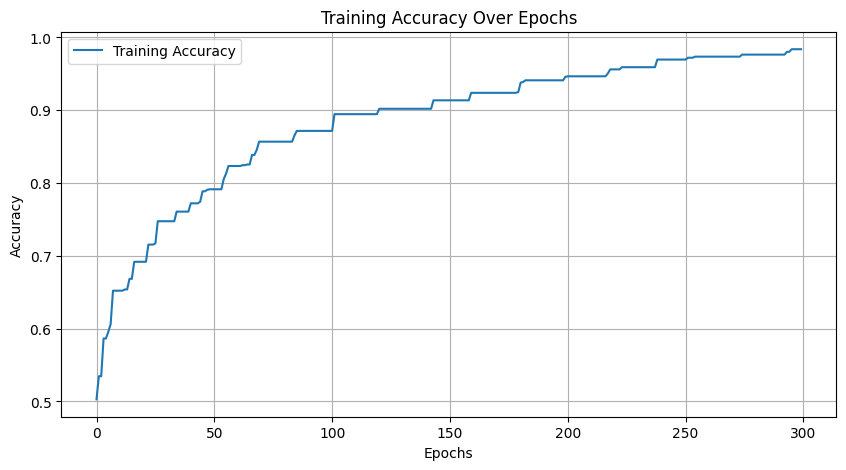

In [ ]:
import matplotlib.pyplot as plt
import re

def plot_accuracy(log_path):
    epochs = []
    accuracies = []
    
    epoch_pattern = re.compile(r'--> Epoch (\d+): .* accuracy: ([\d\.]+);')
    
    with open(log_path, 'r') as f:
        for line in f:
            match = epoch_pattern.search(line)
            if match:
                epoch = int(match.group(1))
                acc = float(match.group(2))
                epochs.append(epoch)
                accuracies.append(acc)
    
    if not epochs:
        print("Nenhum dado de acurácia encontrado no log.")
        return
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, accuracies, linestyle='-', label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

# Caminho do arquivo de log
log_path = './logs/simtsc_ecg_log.txt'
plot_accuracy(log_path)